# Project : News_summary_more
---
## AIFFEL Online 6기 코어 최현우
## LSTM, Attention : Abstractive summary (추상적 요약)
## Summa summarize : Extractive summary (추출적 요약)
---

# Step 1. Data load

In [ ]:
!pip install summa

In [ ]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.8.1
2.14.0
1.5.3
1.2.0


In [ ]:
import urllib.request
import pandas as pd

# 데이터셋을 다운로드합니다.
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

# 데이터셋을 로드합니다.
# 추출적 요약에 사용할 데이터
data_test = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
# 전처리 하여 추상적 요약에 사용할 데이터
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
# data sample Check
data.sample(10)

,headlines,text
41364,Sensitive people should not enter Bollywood: S...,Actress Soha Ali Khan has said that people who...
63780,Jumped into river but my friend saved me: Kail...,"Singer Kailash Kher, while talking about the t..."
45663,3 charred to death as ambulance collides with ...,Three people were charred to death on Wednesda...
53555,I'd be thrilled if my kids want to join B'wood...,"Actress Juhi Chawla, while talking about her 1..."
23879,Jumped out in time as bus fell into gorge: Lon...,"Prakash Sawant Desai, the only person who surv..."
59708,"Maharashtra police acquires 4,600 bullet-proof...","Maharashtra police has reportedly acquired 4,6..."
97915,Pujara 1st to score a ton on 4 different venue...,Indian batsman Cheteshwar Pujara has now score...
39140,Thought I'd be a spinster but met George at 35...,"Human rights lawyer Amal Clooney, the wife of ..."
70525,Pune traffic police unable to recover fines of...,The Pune Traffic Police has reportedly been un...
15172,India-born professor Gita Gopinath named IMF C...,India-born Harvard University professor Gita G...


# Step 2. 데이터 전처리하기 (추상적 요약)

In [ ]:
# 라이브러리 호출하기
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Data 중복 여부 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [ ]:
# text 중복 샘플 제거 (drop_duplicates())
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 text 중복 배제한 샘플수 :', (len(data)))

전체 text 중복 배제한 샘플수 : 98360


In [ ]:
# null 값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [ ]:
# stopwords 리스트 가져오기
# 불용어 리스트를 가져옵니다.
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# 불용어 리스트 체크
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [ ]:
# 정규화 사전 생성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [ ]:
# 데이터를 전처리 함수 정의
import re
from bs4 import BeautifulSoup

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
# 전처리 결과 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary :", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary : great way to start the day


In [ ]:
# text data에 대한 전처리
clean_text = []

# 불용어 제거 (Text)
for x in data['text']:
    clean_text.append(preprocess_sentence(x))
# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [ ]:
# 전체 headlines 데이터에 대한 전처리 : 불용어를 제거하면 문장이 자연스럽지 않거나, 중요한 정보를 잃을 수 있다
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리
for x in data['headlines']:
    # preprocess_sentence 함수를 호출하되, remove_stopwords 인자를 False로 설정합니다.
    clean_headlines.append(preprocess_sentence(x, remove_stopwords=False))

print("Headlines 전처리 후 결과: ", clean_headlines[:5])

<ipython-input-86-e1805a786a73>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [ ]:
import numpy as np

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [ ]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


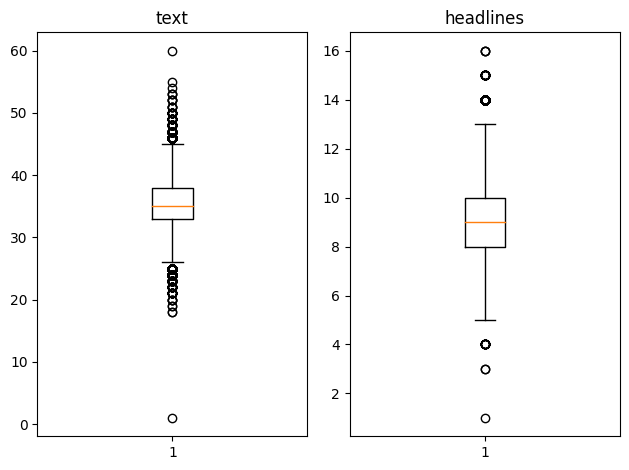

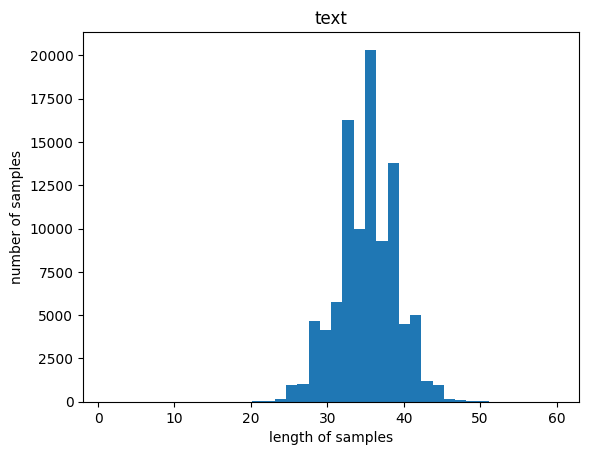

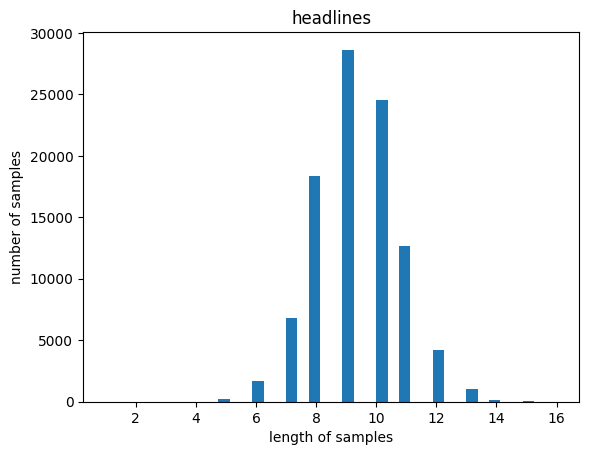

In [ ]:
# 길이 분포 출력
# 이미지를 보고 최대 길이 설정
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 최대 길이 임의로 설정
text_max_len = 50
summary_max_len = 14

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9997763318422123


In [ ]:
# 'text' 열의 각 샘플의 길이가 text_max_len 이하인지 확인
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]

# 'headlines' 열의 각 샘플의 길이가 headlines_max_len 이하인지 확인
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98324


In [ ]:
# SOS, EOS 추가하기
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

<ipython-input-97-19e601da8049>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
<ipython-input-97-19e601da8049>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [ ]:
# 인/디코더의 입력과 레이블 다시 Np 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [ ]:
# data separation
# 정수 시퀀스 생성 (encoder_input과 크기와 형태가 같은 시퀀스)
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[69346  8034 73644 ... 22477 79071 10737]


In [ ]:
# 테스트 데이터 비율 설정 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19664


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78660
훈련 레이블의 개수 : 78660
테스트 데이터의 개수 : 19664
테스트 레이블의 개수 : 19664


In [ ]:
# Vocabulary 생성
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [ ]:
# 빈도수로 희귀 단어 제한
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68165
등장 빈도가 6번 이하인 희귀 단어의 수: 46291
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21874
단어 집합에서 희귀 단어의 비율: 67.91021785373725
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4301126056946143


In [ ]:
# 제한 범위 설정
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[6447, 6854, 8209, 9922, 8770, 1663, 1741, 1990, 1395, 626, 11730, 1745, 2317, 1294, 878, 22, 140, 1227, 1663, 8209, 2560, 604, 349, 950, 5072, 133, 3391, 2303, 1819, 1546, 2174, 8209, 210, 323, 1990, 2187, 62, 8492], [5453, 238, 1276, 1046, 542, 1438, 413, 20457, 600, 101, 2366, 222, 373, 345, 5499, 17, 2, 13680, 8493, 26, 20458, 3701, 2965, 2642, 20457, 4727, 101, 117, 17, 20457, 3524, 124, 2643, 542, 533, 100, 4481, 10389, 3681, 38, 14646, 21875, 11731, 2509], [25, 715, 821, 3, 694, 597, 270, 4678, 72, 222, 7, 88, 89, 88, 270, 144, 3, 263, 118, 88, 795, 236, 5403, 1299, 6518, 1306, 163, 409, 88, 1668, 3, 483, 2466, 2677, 322, 270, 115, 476]]


In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29733
등장 빈도가 3번 이하인 희귀 단어의 수: 16698
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 13035
단어 집합에서 희귀 단어의 비율: 56.15982241953385
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.096538715319085


In [ ]:
tar_vocab = 13000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4976, 8740, 8741, 3, 730, 4, 9454, 1904, 9, 1146, 1147], [1, 26, 3675, 159, 242, 368, 14, 2965, 5, 124, 40, 7], [1, 41, 1236, 339, 453, 553, 485, 8, 160, 633, 3031], [1, 8151, 182, 8152, 1755, 499, 950, 1734, 849, 369], [1, 47, 2159, 2739, 5, 101, 148, 78, 960, 183, 77, 10, 2637, 611]]
target
decoder  [[4976, 8740, 8741, 3, 730, 4, 9454, 1904, 9, 1146, 1147, 2], [26, 3675, 159, 242, 368, 14, 2965, 5, 124, 40, 7, 2], [41, 1236, 339, 453, 553, 485, 8, 160, 633, 3031, 2], [8151, 182, 8152, 1755, 499, 950, 1734, 849, 369, 2], [47, 2159, 2739, 5, 101, 148, 78, 960, 183, 77, 10, 2637, 611, 2]]


In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78660
훈련 레이블의 개수 : 78660
테스트 데이터의 개수 : 19664
테스트 레이블의 개수 : 19664


# Step 2-1. Padding


In [ ]:
# 최대 길이 보다 짧은 데이터들 뒷 공간에 0으로 채우기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# Step 3. 모델 설계하기(LSTM)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# LSTM input size 3차원 (data_size, time_step, feature)
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 50, 128)              2816000   ['input_6[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               [(None, 50, 256),            394240    ['embedding_2[0][0]']         
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

# Step 3-1. 어텐션 매커니즘 사용하기(추상적요약)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs]) # 위에서  변경 encoder_outputs > encoder_output3 변경

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 50, 128)              2816000   ['input_6[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               [(None, 50, 256),            394240    ['embedding_2[0][0]']         
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

# 3-2. 모델 훈련하기

In [ ]:
# 모델 훈련하기
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=128, callbacks=[es], epochs=50)

Epoch 1/50
615/615 [==============================] - 71s 103ms/step - loss: 5.0749 - val_loss: 4.5568
Epoch 2/50
615/615 [==============================] - 45s 72ms/step - loss: 4.4431 - val_loss: 4.0647
Epoch 3/50
615/615 [==============================] - 44s 72ms/step - loss: 3.9235 - val_loss: 3.7374
Epoch 4/50
615/615 [==============================] - 45s 74ms/step - loss: 3.5450 - val_loss: 3.5463
Epoch 5/50
615/615 [==============================] - 45s 72ms/step - loss: 3.2646 - val_loss: 3.4267
Epoch 6/50
615/615 [==============================] - 44s 72ms/step - loss: 3.0449 - val_loss: 3.3495
Epoch 7/50
615/615 [==============================] - 45s 73ms/step - loss: 2.8638 - val_loss: 3.3042
Epoch 8/50
615/615 [==============================] - 45s 73ms/step - loss: 2.7103 - val_loss: 3.2824
Epoch 9/50
615/615 [==============================] - 45s 73ms/step - loss: 2.5789 - val_loss: 3.2689
Epoch 10/50
615/615 [==============================] - 45s 73ms/step - loss: 2.46

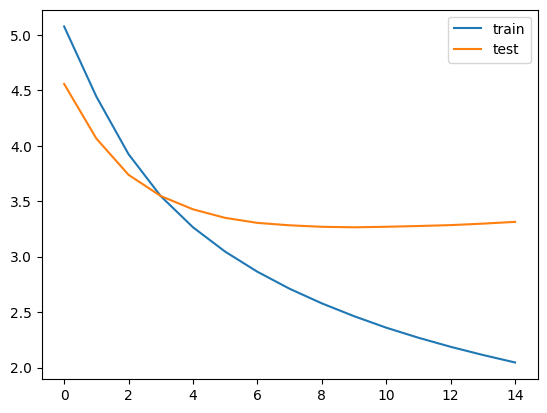

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 3-3. 인퍼런스 모델 구현하기

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h3, state_c3 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h3, state_c3])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    # 조건 숫자 0, SOS, EOS 제외
    temp=''
    for i in input_seq:
        if (i !=0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp += tar_index_to_word[i] + ''
    return temp.strip()

print('=3')

=3


In [ ]:
for i in range(60, 70):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : sania mirza called indian women team captain mithali raj incredible ambassador game cricket mithali performing amazingly many years really hope appreciation girls getting continues deserve said sania mithali became first indian captain lead team two odi world cup finals
실제 요약 : mithalianincredibleambassadorforcricketsaniamirza
1/1 [==============================] - 0s 20ms/step
예측 요약 :  kapil dev has to be part of kapil dev kapil dev


원문 : doctors telangana biggest government run gandhi hospital hyderabad chanted mantra bring rising number deaths newborns hospital patients complained unavailability doctors pooja reportedly approved senior doctors went hours probe ordered case
실제 요약 : docschantmantraforhourstobringdowndeathsinhospital
1/1 [==============================] - 0s 28ms/step
예측 요약 :  mp doctors die after being denied entry to hospital


원문 : five men forced aggressive female passenger united airlines flight sunday began screaming charging towards cockpit according repor

# Step 5. Summa를 이용해서 추출적 요약해보기

In [ ]:
!pip install --upgrade summa

In [ ]:
from summa.summarizer import summarize

# 람다식으로 바로 summarize 적용할 수 있으나 함수 생성 연습으로 구현!
# data['extractive_summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.05))

# 추출적 요약을 위한 함수 정의(텍스트, 논문 보존 비율 ratio arg)
# ratio 값에 따라 요약을 반환하지 않을 수 있다
def extractive_summary(text, ratio=0.4):

    return summarize(text, ratio=ratio)

# 전처리된 텍스트 데이터에 대해 추출적 요약을 수행
extractive_summaries = data_test['text'].apply(extractive_summary)

In [ ]:
print(data_test['text'])

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object


In [ ]:
# 추출적 요약이 안됨! 혹시 데이터의 문장이 짧아서 안되는 건지 확인 (문장의 길이는 큰 영향이 없음)
# Summa Summarize 는 키워드 추출 시 대소문자 구분, 특수기호 들을 기준으로 추출해서 유사성을 계산한다.
# 이 프로젝트에서 전처리 된 데이터는 워드 추출하기 어렵다.
long_text = """
The program and upGrad's 360-degree career support helped him transition to a
Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.
"""
print(summarize(long_text, ratio=0.4))

The program and upGrad's 360-degree career support helped him transition to a 


In [ ]:
# 문장의 길이 영향으로 요약을 못하는지 테스트 : 텍스트 길이 컬럼 생성해서 제일 긴 텍스트 찾아서 summarize 적용해보자
# preprocessing data

data['text_length'] = data['text'].apply(len)
longest_text_index = data['text_length'].idxmax()
longest_text = data.loc[longest_text_index, 'text']

# Summa summarize 적용
longest_text_summary = extractive_summary(longest_text)

# 결과 출력
print(f"가장 긴 원본 뉴스: {longest_text}")
print(f"추출적 요약: {longest_text_summary}")

가장 긴 원본 뉴스: drive next generation experiencechange says brand ambassador aamir khan datsun introduces new go go powered japanese engineering presenting first segment best class features advanced safety superior technology connected mobility features include dual front air bags premium interiors touchscreen infotainment system equipped voice recognition android auto apple car play
추출적 요약: 


In [ ]:
# 노드 코드 참조
print('Summary:')
print(summarize(data_test['text'].iloc[0], ratio=0.5))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [ ]:
# 원본 데이터
data_test['text'].iloc[0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [ ]:
# 전처리 된 데이터
data['text'].iloc[0]

'saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'

In [ ]:
# 추출적 요약 결과 출력
for i, summary in enumerate(extractive_summaries[:5]):
    print(f"원본 뉴스 {i+1}: {data_test['text'].iloc[i]}")
    print(f"추출적 요약 {i+1}: {summary}")
    print("\n")

# 왜 추출이 안될까? Summa summarize는 전처리 데이터의 단어와 추출 형태가 안 맞았음. ratio 값도 0.5 설정해서 요약 가능 (0.3 이하로는 요약 X)

원본 뉴스 1: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
추출적 요약 1: upGrad's Online Power Learning has powered 3 lakh+ careers.


원본 뉴스 2: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
추출적 요약 2: Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


원본 뉴스 3: New Zealand defea

---
# 6. 회고록

# 하면서 배우고 찾아봤던 점
1. 문장의 길이에 따라서 적절한 ratio 값을 설정해주지 않으면 요약이 안됩니다(Summa summarize)
2. 문장의 길이 때문에 Summa 요약이 안된다 판단하여 여러 비교
(원본, 전처리 데이터 비교 및 새로운 텍스트 요약, 같은 문장 길이 감소 등)

* 결론 : Summa summarize 는 TextRank 알고리즘을 사용, 대소문자/특수기호 등으로 단어를 추출해서 유사성을 계산하지만 전처리 된 데이터는 단어의 불확실성, 소문자화, 특수기호 삭제 등으로 요약이 안되었습니다.
* **raito** 값도 적절히 조절하지 않으면 출력이 안되었습니다.

# 추출/추상적 요약 비교

|요약 타입|문장 완성도|설명|
|:---|---:|:---:|
|Extractive summary|완전함|확실히 원본에서 단어를 가져다 사용해서 그런지 요약하는 속도나 완성도가 상대적으로 높았습니다.|
|Abstractive summary|부족함|엉뚱한 단어가 튀어 나오기도 하고, 일부만 요약하는 모습을 보였습니다. 그러나 다양한 표현을 하려는 모습 확인 했습니다.|

# 추출/추상 요약 예시
1. Extractive summary

원본 : New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.

* 추출적 요약: The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.

번역 : 뉴질랜드는 목요일 해밀턴에서 열린 네 번째 ODI에서 인도를 8위켓으로 꺾고 5경기 ODI 시리즈의 첫 경기에서 승리했습니다. 인도는 2018년 3월부터 12연승을 거둔 후 Rohit Sharma의 주장 아래 국제 경기에서 패했습니다. 이 경기에서 인도는 ODI 크리켓 역사상 7번째로 낮은 합계인 92점을 기록했습니다.

* 추출적 요약: 이 경기에서는 인도가 ODI 크리켓 역사상 7번째로 낮은 합계인 92점을 기록했습니다.
---
2. Abstractive summary

원문 : shiv sena leader sunil booked culpable homicide collapse four storey building people killed mumbai ghatkopar tuesday owned building ground floor reportedly carried illegal renovations weakened building interestingly building mumbai civic body list unsafe buildings year
* 실제 요약 : shivsenaleaderarrestedovermumbaibuildingcollapse
* 예측 요약 : shiv sena leader shifted to fire in stampede

번역 : hiv sena 리더 수닐은 과실치사 붕괴 4층 건물 사람들이 사망했습니다 뭄바이 가트코파르 화요일 소유 건물 1층은 불법 개조 공사를 진행한 것으로 알려졌습니다 약화된 건물 흥미롭게도 뭄바이 시민 단체 목록 안전하지 않은 건물 연도
* 실제 요약 : 시브세날리더, 뭄바이 건물 붕괴로 체포
* 예측 요약 : 시브 세나 리더가 휩쓸려 불타올랐다